In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

from google.colab import files

# Upload kaggle.json file that you downloaded
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

In [4]:
%cd train
%rm -rf disgust/
%rm -rf fear/

%cd ..
%cd test
%rm -rf disgust/
%rm -rf fear/

%cd ..

/content/train
/content
/content/test
/content


In [5]:
NO_OF_CLASSES = 5
IMG_SIZE = 224

In [6]:
# Create the base model from the pre-trained model ResNetV2.
base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                           include_top=False,
                                           weights='imagenet',
                                           pooling='avg')

for layer in base_model.layers[:160]:
    layer.trainable = False

base_model.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

In [7]:
model = keras.Sequential(name="EmoSenseNet")
model.add(base_model)
model.add(keras.layers.Dense(4096, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(NO_OF_CLASSES, activation="softmax"))

model.summary()

Model: "EmoSenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 36157957 (137.93 MB)
Trainable params: 27

In [8]:
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [9]:
train_path = "train/"
test_path = "test/"

# Given preprossing function transforms intensity values between -1 to 1.
train_data_generator = ImageDataGenerator(preprocessing_function=keras.applications.resnet_v2.preprocess_input,
                                          rotation_range=5,
                                          width_shift_range=0.05,
                                          height_shift_range=0.05,
                                          zoom_range=0.05,
                                          horizontal_flip=True)

test_data_generator = ImageDataGenerator(preprocessing_function=keras.applications.resnet_v2.preprocess_input)

In [10]:
train_batches = train_data_generator.flow_from_directory(directory=train_path,
                                                         target_size=(IMG_SIZE, IMG_SIZE),
                                                         batch_size=32,
                                                         color_mode="rgb",
                                                         class_mode="categorical",
                                                         shuffle=True,
                                                         interpolation="bicubic")

test_batches = test_data_generator.flow_from_directory(directory=test_path,
                                                       target_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=32,
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       shuffle=False,
                                                       interpolation="bicubic")


Found 24176 images belonging to 5 classes.
Found 6043 images belonging to 5 classes.


In [11]:
print(train_batches.class_indices)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3, 'surprise': 4}


In [13]:
# Create a directory to save models
save_dir = '/content/drive/MyDrive/Colab Notebooks/160_Adam_5/1/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, "epoch_{epoch:03d}.h5")
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=False,
                                             save_best_only=False,
                                             save_freq='epoch')


In [14]:
history = model.fit(train_batches,
                    epochs=20,
                    validation_data=test_batches,
                    callbacks=[checkpoint])

Epoch 1/20
756/756 [==============================] - ETA: 0s - loss: 1.0275 - accuracy: 0.6092

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


756/756 [==============================] - 387s 480ms/step - loss: 1.0275 - accuracy: 0.6092 - val_loss: 0.9688 - val_accuracy: 0.6303
Epoch 2/20
756/756 [==============================] - 351s 464ms/step - loss: 0.8203 - accuracy: 0.6947 - val_loss: 0.8205 - val_accuracy: 0.7021
Epoch 3/20
756/756 [==============================] - 353s 466ms/step - loss: 0.7423 - accuracy: 0.7225 - val_loss: 0.7833 - val_accuracy: 0.7102
Epoch 4/20
756/756 [==============================] - 356s 471ms/step - loss: 0.6899 - accuracy: 0.7441 - val_loss: 0.7501 - val_accuracy: 0.7207
Epoch 5/20
756/756 [==============================] - 354s 469ms/step - loss: 0.6475 - accuracy: 0.7643 - val_loss: 0.7293 - val_accuracy: 0.7319
Epoch 6/20
756/756 [==============================] - 359s 475ms/step - loss: 0.6098 - accuracy: 0.7736 - val_loss: 0.7144 - val_accuracy: 0.7382
Epoch 7/20
756/756 [==============================] - 351s 465ms/step - loss: 0.5753 - accuracy: 0.7914 - val_loss: 0.7693 - val_accura

In [15]:
import pickle
# Save the training history to a file
with open('/content/drive/MyDrive/Colab Notebooks/160_Adam_5/history1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

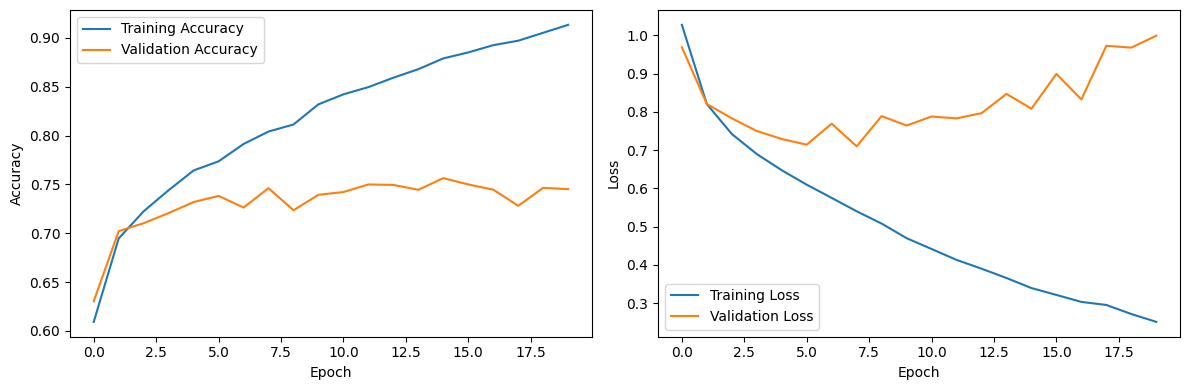

In [16]:
# Plot training accuracy and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()